# Project 3: Collaboration and Competition

### Introduction

The goal of this project was to train two agents learning to play in [Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) environment.

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation.  Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

The task is episodic, and in order to solve the environment, the agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single **score** for each episode.

The environment is considered solved, when the average (over 100 episodes) of those **scores** is at least +0.5.


In [3]:
from unityagents import UnityEnvironment
from agent import Agent
import torch
import numpy as np
from collections import deque
from matplotlib import pyplot as plt

I have trained the model by running the train.py file from the command line since with Jupyter Notebook it tends to loose connection constantly if I don't keep it active everyonce in a while. So to make it easier for me I decided to train it locally from command line. Therefore I kept track of the scores in `.npz` file and I will show how the scores changed below.

In [4]:
scores = list(np.load("scores.npz")["scores"])
scores_window = deque(maxlen=100)
i_ep = 1
for each in scores:
    scores_window.append(each)
    print('\rEpisode {} \tAverage Score: {:.2f}, Max score: {}, Min score: {}'.format(i_ep, np.mean(scores_window), np.max(scores_window), np.min(scores_window)), end="")
    if i_ep % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)))
    i_ep += 1

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.07
Episode 700	Average Score: 0.10
Episode 800	Average Score: 0.11
Episode 900	Average Score: 0.10
Episode 1000	Average Score: 0.12
Episode 1100	Average Score: 0.14
Episode 1200	Average Score: 0.22


Episode 1300	Average Score: 0.27
Episode 1400	Average Score: 0.40
Episode 1500	Average Score: 0.47
Episode 1600	Average Score: 0.49
Episode 1607 	Average Score: 0.50, Max score: 2.600000038743019, Min score: 0.0

# Scores plot

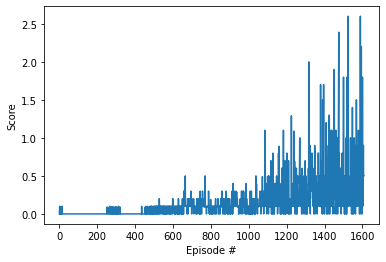

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Performance

In [6]:
env = UnityEnvironment(file_name='Tennis/Tennis.exe') 
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name] # set False if you wish to visualize the environment
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### Trained Agent's Performance

In [12]:
agents = [Agent(state_size, action_size, 0),Agent(state_size, action_size, 0)]
agents[0].network.actor.load_state_dict(torch.load("actor_0_solution.pth"))
agents[1].network.actor.load_state_dict(torch.load("actor_1_solution.pth"))
env_info = env.reset(train_mode=False)[brain_name]
score = np.zeros(2)
for t in range(1000):
    actions = [agents[0].act(torch.from_numpy(env_info.vector_observations[0]).float(), add_noise=False),
               agents[1].act(torch.from_numpy(env_info.vector_observations[1]).float(), add_noise=False)]
    env_info = env.step(actions)[brain_name]
    score += env_info.rewards
print("Final score:", np.max(score))

Final score: 2.600000038743019


# Hyperparameters, Learning Algorithm and Network Architecture

Bringing these together was a long journey. A lot of trial and error and finally something that made it work and reach the goal.

### Hyperparameters

```
BUFFER_SIZE = int(1e6)    # Memory size, the last number of steps it stores
BATCH_SIZE = 256          # Batch size used to train the model 
ACTOR_LR = 1e-4           # Learning rate for the Actor model
CRITIC_LR = 1e-3          # Learning rate for the Critic model
WEIGHT_DECAY = 0          # Weight decay (used for Critic)
TAU = 1e-3                # TAU used to determine how much of local impacts the target
GAMMA = 0.99              # Discount rate
UPDATE_EVERY = 1          # Learn every few steps 
TIMES_UPDATE = 1          # Number of time to learn
```

I have used a relatively large buffer size for it to remember many time step. For batch size I have tried several from 32 to 256, and the one that seemed to give most stable learning was 256, with anything lower it was really hard for me to see whether it was learning much or not.

For learning rate, I used 1e-4 for the actor network, and 1e-3 for the critic model. A higher learning rate in here did not seem to make any improvement, rather it seemed that after few episodes of improvement it falls and does not give any sign of recovery. After serveral trial and error this seemed to keep the model on constant learning for 2000+ episodes.

For TAU and GAMMA I kept it same as the ones I saw in the paper for DDPG. For this project I feel like UPDATE_EVERY and TIMES_UPDATE really played a big role. Increase less frequent update, seemed to not really help the growth. Rather I for first one to two thousand episode it wouldnt show any growth. After trial and error, it seemd to show improvement when it was learning every timestep. Now with times update, at the beginning having a higher number helped it grow faster but then later at the end it would seem to be stuck. At the end, setting to 1 seemed ideal for me, given any higher value took a lot of time in my laptop.

Some parameters not mentioned above are the ones related to the parameters for adding noise.
```
 mu=0., theta=0.15, sigma=0.2
```
I brought the class for noise from hte classrom, which I have referred in the source code, and I kept the original values. It seemed to work fine so I didn't really change it. I have modifed the class and added a get_action method that just adds the noise to the network's action output, and clips it to its range. I kept it in the noise class instead of adding it to the agents act method.

### Network Architecture

I have tried to multi agent DDPG. Each agent had the exact same network architecture. The actor model was a 3 layer neural network, the first hidden layer consisted of 256 nodes, second had 128, and the last was the output layer. The critic model was of 4 layer, the first hidden lyaer had 256 nodes, second had 128, third had 128, and the last was the output layer. Both model used leaky_relu in their hidden layer and took their own state as input. From my experience with second project, I kept usign leaky_relu since it seemed to perform the best in DDPG.

In the critic model, in my final submission I only have the action of the current agent added to its second layer. I did try following the MADDPG paper and added actions and states of both agents to the critic model, but I wasn't able to see any improvement in the performance. For the same hyperparameters I had the training on for 5000 episodes but average score did not go avobe 0.02. When I tried just current agents action, I was able to see some growht in first 1000 episodes, so I decided to stick with that.

### Learning Algorithm

I used the learning algorithm specified in the DDPG paper. First I updated the critic of the model. There was a target network
that would take the next states and actions to determine the target value for current states using:
`Q_target = rewards + (gamma * Q_targets_next * (1-dones)`
Then using the critic network the predicted values are gathered
`Q_predicted = network.critic(states, actions)`
Then using MSE the loss is determined for the critic to backpropage the critic network's parameters. One more thing that i kept in my code from the benchmark guideline was to clip the gradients for critic model.

To update the actor model, it used the local critic networks negative value as loss. From the sampled experience it would take the states and actions taken by agent to determine the Q value of those. The loss would be averaged and negative value of it. So the actor model would learn to determine actions that would maximize the Q value. Averaging allows it to be more stable in learning.

During training, it was set so that for each episode it would iterate over for 1000 timesteps, and it will continue on the episodes until the average score of 0.5+ is achieved.

# Problems and Improvement

Well the first bitter taste in my mouth is not fully utilising the concepts from the MADDPG paper. I do wanna try more on the network architecture to see if we can have a better performing model by providing more information. Also above when visualizing I noticed in a lot of the scenarios, the agents made a lot of unnecessary movements. While this was not part of the goal at all, but I think it would be nice to see more cleaner moves. Maybe further training could help improve this, but I think by sharing both states to the model, this could possibly also pick up on this. Because from the state if the agent can understand it is not the one receiving the ball, it does not need to move up and down again and again.

Secondly, I am not very happy about the number of episodes it took to learn, I think this could be improved a lot by using Prioritized Experience Replay. At the moment both agent refer to a single instance of memory, but they use their own experiences, but I think in this case we could train the agent with each others expereince as well, as in most cases it should be quite similar. I have tried swapping the parameters for agents and it still performed well, which supports this idea of mine I think.

I am also curisous to see if changing the optimzier would make any difference, as in both cases I used Adam and through the whole trial and error process I never changed it. So I would like to see if this would make any difference in the progresss.

Once again, I think it might help to have a network to extrapolate features from the state and then feed that into the actor and critic network. This might help the agents to pick on more info, and features network could be a single network shared with both agents. I think this would also help a lot if we were to share the memory.

Another interesting thing to try could be is using different network architecture for different agents. While in this case it shouldn't help significantly as both agent have the same goal and reward system, but it would still be interesting to see if it can make a difference.

The last thing I sort of wanna mention, is that I see the agents sort of repeating the same action that keeps the ball on air and in boundary, but which is kind of boring. It might be more interesting to make the agent try to score against the other, so here I think it will be good if the reward system was slightly changed. So it could be something simpler, if agent misses the ball or out of boundary -0.1, and if it scores against +0.1. 